### Set up first DeepESN model

**Outline**

Use customized implementation of ESN layer with customized functions from **ESN_functions_v02.py** for setting up ESN model, training model and getting predictions with evaluation metrics.

* Apply **additive decomposition** of timeseries into linear trend, seasonality and residual noise, as in [Kim and King, 2020](https://link.springer.com/article/10.1007/s00521-020-04948-x) paper "Time series prediction using Deep Echo State Networks", we are soon ready to switch from base ESN to Deep ESN models.
* Work with **stock index** values (S&P 500).

#### Technical setup: Import libraries and customized own functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate
import tensorflow.keras.initializers as tfi
from tensorflow.keras.utils import plot_model

# Work with my own library of useful ESN functions
from ESN_functions_v02 import *

In [3]:
# Read dataset SP500_1999_2019.txt, absolute values:
SP500_abs = open("../data/SP500_1999_2019.csv").read().split()
SP500_abs = np.array(SP500_abs).astype('float64')

#### Declare global (hyper-)parameters upfront

In [4]:
## Verbosity
verbose = True

## Decomposing timeseries:
input_length = 10 # Split input series into samples of specified input length.
target_length = 1 # Define target length.
train_val_split = 0.8 # Specify the amount of samples used for training, the rest is used as validation data.
alpha = 0.15 # Smoothing parameter for decomposing original series into trend L, season S and residuum R.
gamma = 0.15 # Smoothing parameter for decomposing original series into trend L, season S and residuum R.
s = 126 # Choose cycle length for season S.
scaled_YN = True # If True: Scale input series with min/max scaling, where min/max are taken only from train data!

## ESN model
n_layers = 3 # Number of ESN layers in the model.
n_res = 100 # Number of reservoir units.
W_in_lim = 1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 0.5 # Leak rate used in transition function of reservoir states.
spec_radius = 1.0 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix
sparsity = 0.2 # Sparsity of reservoir weight matrix.
n_features = 4 # Number of input features, e.g. original series plus decomposed parts L, S and R --> 4

#### Prepare input data

original input series shape:  (5000, 1)
train_input shape:  (3992, 10, 4)
val_input shape:  (998, 10, 4)
train_target shape:  (3992, 1)
val_target shape:  (998, 1)
train_min:  676.53
train_max:  2130.82


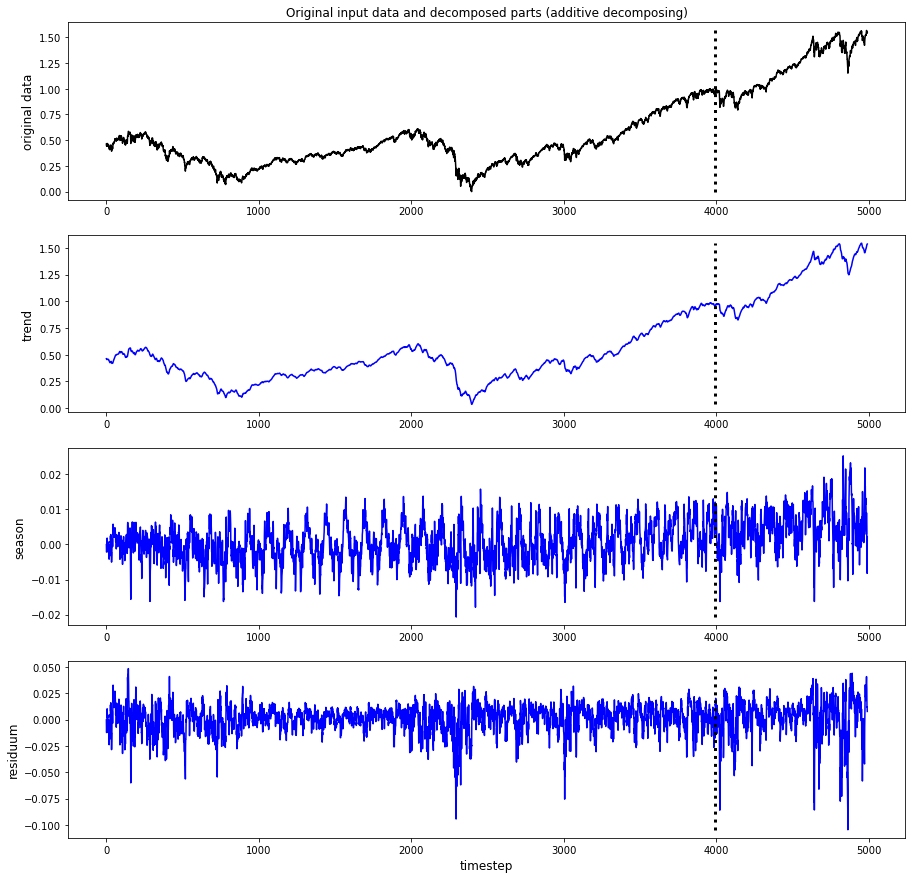


original:
ADF Statistic: 0.937927
p-value: 0.993566

Trend L:
ADF Statistic: 1.063965
p-value: 0.994897

Season S:
ADF Statistic: -9.959887
p-value: 0.000000

Residuum R:
ADF Statistic: -13.925091
p-value: 0.000000


Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [5]:
# Scale, decompose and split input timeseries.
# End up with 4 input features: Original (scaled) series plus decomposed parts: Trend L, season S and residuum R.
train_input, val_input, train_target, val_target, input_min, input_max = decompose_split(SP500_abs,
                                                                                         input_length=input_length,
                                                                                         target_length=target_length,
                                                                                         train_val_split=train_val_split,
                                                                                         alpha=alpha,
                                                                                         gamma=gamma,
                                                                                         s=s,
                                                                                         scaled_YN=scaled_YN,
                                                                                         verbose=verbose)

In [6]:
## Set up ESN model:

# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
model, model_short = setESN(input_length=input_length, n_features=n_features, n_layers=3, n_res=n_res,
                            W_in_lim=W_in_lim, leak_rate=leak_rate, spec_radius=spec_radius, sparsity=sparsity,
                            verbose=verbose)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpqhol1v_y.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpqhol1v_y.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-02-25 10:04:55.516226: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 4)]      0                                            
__________________________________________________________________________________________________
esn (ESN)                       ((None, 10, 100), (N 10600       input_1[0][0]                    
__________________________________________________________________________________________________
esn_1 (ESN)                     ((None, 10, 100), (N 20200       esn[0][0]                        
__________________________________________________________________________________________________
esn_2 (ESN)                     ((None, 10, 100), (N 20200       esn_1[0][0]                      
______________________________________________________________________________________________

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v02.py:466: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v02.py:505: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


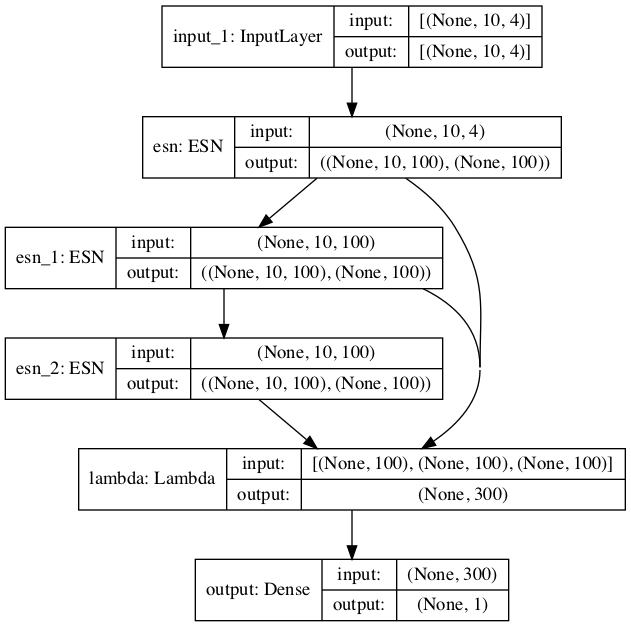

In [7]:
# Plot complete model
plot_model(model, show_shapes=True, show_layer_names=True)

### Solving for output weights with linear regression, use "augmented" notation

Short model yields final reservoir states $X(T)$ with dimension (#samples, #reservoir units). We then have outputs weights $W_{out}$ with shape (#reservoir units, 1) and output bias $b_{out}$ as single value. Train targets $Y$ have dimension (#samples, 1).

The relation between final reservoir states, output weights and bias and train targets $Y$ reads:

$$X(T) \cdot W_{out} + \overline{b}_{out} = Y$$

Note: Here $\overline{b}_{out}$ denotes a vector of shape (#samples, 1), containing only the single output bias value $b_{out}$.

We switch to "augmented" notation and include ${b}_{out}$ as additional weight $W_{out}$. This requires to add a column of *ones* as last column of $X(T)$, for keeping dimensions right. This leads to:

$$X'(T) \cdot W'_{out} = Y$$

where $X'(T)$ and $W'_{out}$ denote final reservoir states and output weights in augmented notation, respectively. Note: Later we might omit the primes - for convenience.

Solving for $W'_{out}$ we need to invert $X'(T)$, or get the pseudo-inverse $X'_{inv}$, since $X'(T)$ is usually not a square matrix:

$$W'_{out} = X'_{inv} \cdot Y$$

Doing this, we obtain trained output weights and bias. Then extract the bias (= last entry in $W'_{out}$) and plug train output weights and bias back into the model.

In [11]:
# Get final reservoir states for all train samples from short model
print("\nshape of train input (samples, timesteps, features): ", train_input.shape)
X_T_train = model_short.predict(train_input)
print("shape of model output X_T (samples, n_res): ", X_T_train.shape)


shape of train input (samples, timesteps, features):  (3992, 10, 4)
shape of model output X_T (samples, n_res):  (3992, 300)


In [12]:
# Extract output weights and bias.
# Note: output layer is the LAST layer of the model, find weights and bias at position "-2" and "-1", respectively.
model_weights = np.array(model.get_weights())
W_out = model_weights[-2]
b_out = model_weights[-1]
print("\nW_out shape: ", W_out.shape)
print("b_out shape: ", b_out.shape)
#print("\nW_out: \n", W_out)
print("\nb_out before training: \n", b_out)


W_out shape:  (300, 1)
b_out shape:  (1,)

b_out before training: 
 [-0.4011855]


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_3413/981223782.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


In [13]:
# Create vector of shape (samples, 1) containing ONEs to be added as additional column to final reservoir states.
X_add = np.ones((X_T_train.shape[0], 1))
print("\nX_add shape: ",  X_add.shape)


X_add shape:  (3992, 1)


In [14]:
# Now add vector of ONEs as additional column to final reservoir states X_T_train.
X_T_train_prime = np.concatenate((X_T_train, X_add), axis=-1)
print("\nFinal reservoir states in augmented notation, shape: ", X_T_train_prime.shape)


Final reservoir states in augmented notation, shape:  (3992, 301)


In [15]:
# Then need pseudo-inverse of final reservoir states in augmented notation
X_inv_prime = np.linalg.pinv(X_T_train_prime)

# Then get output weights, in augmented notation
W_out_prime = np.matmul(X_inv_prime, train_target)

print("train_input shape: ", train_input.shape)
print("train_target shape: ", train_target.shape)        
print("W_out_prime shape: ", W_out_prime.shape)

train_input shape:  (3992, 10, 4)
train_target shape:  (3992, 1)
W_out_prime shape:  (301, 1)


In [17]:
# Now split output weights in augmented notation into trained output weights W_out and output bias b_out.
W_out = W_out_prime[:-1,:]
b_out = W_out_prime[-1:,0]
#print("\nW_out: \n", W_out)
print("\ntrained b_out: \n", b_out)


trained b_out: 
 [1001.27918582]


In [18]:
# Integrate trained output weights and bias into model weights
model_weights[-2] = W_out
model_weights[-1] = b_out
model.set_weights(model_weights)


shape of val input (samples, timesteps, features):  (998, 10, 4)
shape of train input (samples, timesteps, features):  (3992, 10, 4)

shape of model predictions on validation input (samples, 1):  (998, 1)
shape of val targets (samples, 1):  (998, 1)

val_mae:  320.0777
train_mae:  0.0075


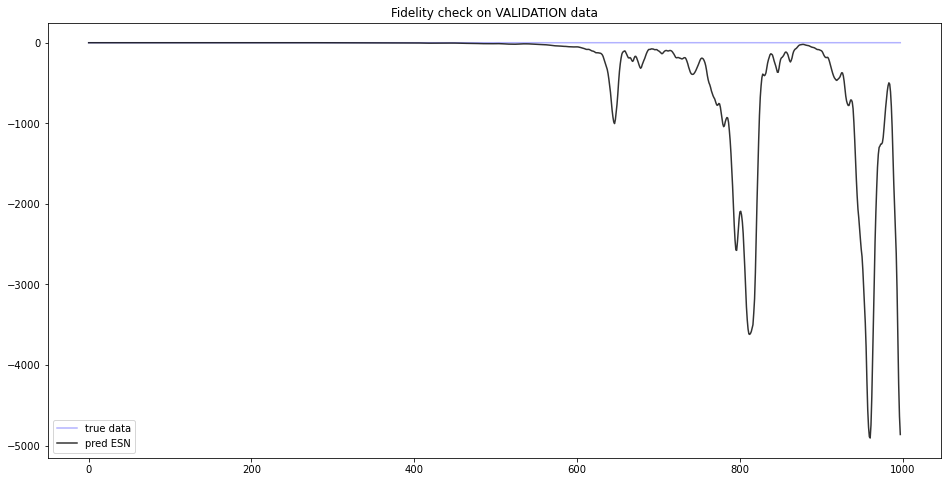

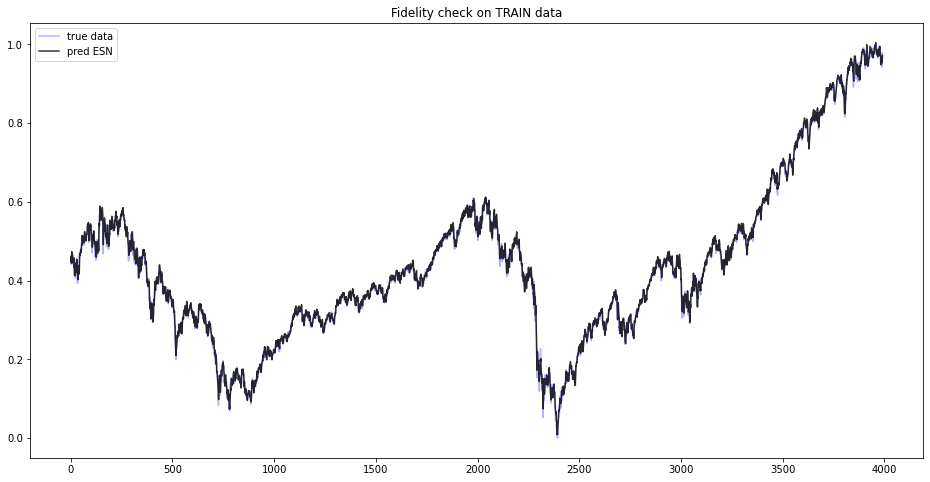

In [19]:
## Get predictions from "long" model on train and validation input
print("\nshape of val input (samples, timesteps, features): ", val_input.shape)
print("shape of train input (samples, timesteps, features): ", train_input.shape)
val_pred = model.predict(val_input)
train_pred = model.predict(train_input)

print("\nshape of model predictions on validation input (samples, 1): ", val_pred.shape)
print("shape of val targets (samples, 1): ", val_target.shape)

# Calculate mean-absolute and mean-squared error of model predictions compared to validation targets:
val_mae = np.round(sum(np.abs(val_target[:,0] - val_pred[:,0])) / len(val_target), 4)
train_mae = np.round(sum(np.abs(train_target[:,0] - train_pred[:,0])) / len(train_target), 4)
print("\nval_mae: ", val_mae)
print("train_mae: ", train_mae)


# Fidelity check: Plot val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred,'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data')
plt.legend()
plt.show()


# Fidelity check: Plot train_pred vs. train_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(train_target)),train_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(train_pred)),train_pred,'k',  alpha=0.8, label='pred ESN')
#plt.plot(range(len(train_pred)),(train_target[:,0]-b_out),'r',  alpha=0.8, label='pred ESN w/out b_out!!!')
plt.title('Fidelity check on TRAIN data')
plt.legend()
plt.show()

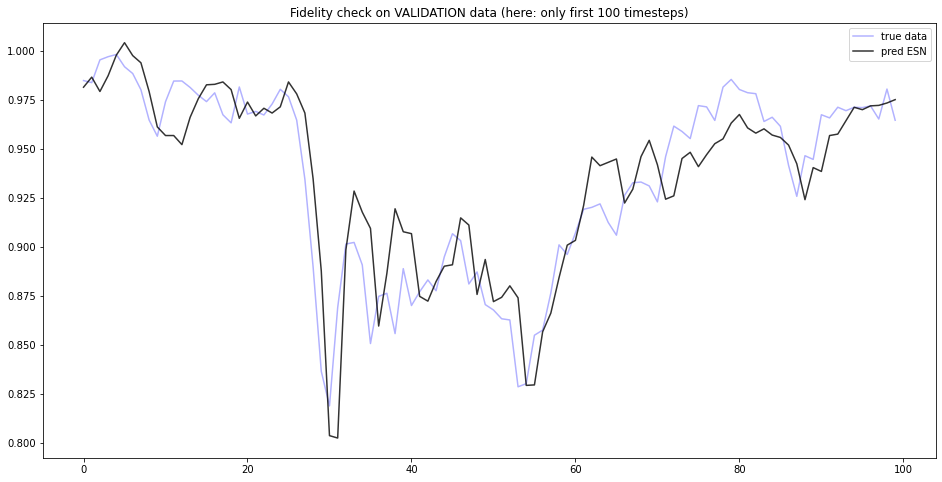

In [20]:
# Fidelity check: Plot only first 100 timesteps of val_pred vs. val_targets
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target[:100])),val_target[:100],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred[:100])),val_pred[:100],'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data (here: only first 100 timesteps)')
plt.legend()
plt.show()